In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import json
import argparse
import copy
from tqdm import tqdm
import torch

import warnings

def short_formatwarning(msg, category, filename, lineno, line=None):
    return f"{os.path.basename(filename)}:{lineno}: {category.__name__}: {msg}\n"

warnings.formatwarning = short_formatwarning
warnings.filterwarnings("always", category=RuntimeWarning)

from cosmoglint.utils import MyDataset
from cosmoglint.utils.io_utils import normalize, namespace_to_dict
from cosmoglint.model import transformer_model

from matplotlib.colors import LogNorm

gpu_id = 0
device = torch.device("cuda:{:d}".format(gpu_id) if torch.cuda.is_available() else "cpu")

def plot_running_mean(x, value, window_size, show_diff=False, ymin=None, **kwargs):
    cumsum = np.cumsum(np.insert(value, 0, 0))
    y = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
    x = x[window_size-1:]

    if len(y) == 0:
        print("Warning: No data to plot.")
        return None, None
    
    if show_diff:
        ymin = y.min() - 1e-3 if ymin is None else ymin
        y -= ymin
        print("ymin plot: ", ymin)
        plt.plot(x, y, **kwargs)
    else:
        plt.plot(x, y, **kwargs)
    
    return x, y


def calc_length(x, threshold, ref_param=0, skip_length=1): 
    # skip the first element (central)
    # generated: (num_samples, seq_length, num_features_in)
    num_samples, seq_length, num_features_in = x.shape
    length = np.zeros(num_samples, dtype=int)
    for i in range(num_samples):
        count = skip_length
        for j in range(skip_length, seq_length):
            count = j
            if x[i,j,ref_param] < threshold:
                break
        length[i] = count
    return length

def calc_ngal_th(x, threshold, ref_param=0): 
    # skip the first element (central)
    # generated: (num_samples, seq_length, num_features_in)
    num_samples, seq_length, num_features_in = x.shape
    ngal = np.zeros(num_samples, dtype=int)
    for i in range(num_samples):
        if x[i,0,ref_param] > threshold:
            ngal[i] += 1
        for count, j in enumerate(range(1, seq_length)):
            if x[i,j,ref_param] < threshold:
                break
        ngal[i] += count

    return ngal

def my_savefig(fout, tight_layout=True):
    if tight_layout:
        plt.tight_layout()
    plt.savefig(fout, bbox_inches="tight")
    print(f"Saved figure to {fout}")

_param_names = [r"${\rm SFR}$", r"${d}$", r"${v}_r$", r"${v}_\theta$"]
param_names = [r"$\rm SFR \ [M_\odot /yr]$", r"$d\ [{\rm Mpc}/h]$", r"$v_r \ \rm [km/s]$", r"$v_\theta \ \rm [km/s]$"]

param_labels = ["sfr", "d", "vr", "vt"]

base_dir = "../scripts/runs/output_transformer"


# Load Model and Plot Loss

opt:  Namespace(gpu_id='0', output_dir='./runs/output_transformer/transformer1_33_ep40_bs512_w0.02', seed=12345, max_length=50, input_features=['GroupMass'], output_features=['SubhaloSFR', 'SubhaloDist', 'SubhaloVrad', 'SubhaloVtan'], global_features=None, data_path=['../dataset/TNG300-1/TNG300-1_33.h5'], indices=None, norm_param_file='../dataset/param_files/norm_params_33.json', global_param_file=None, train_ratio=0.9, batch_size=512, num_epochs=40, lr=0.0001, dropout=0.0, sampler_weight_min=0.02, lambda_penalty_loss=0, save_freq=10, exclude_ratio=0.5, model_name='transformer1', d_model=128, num_layers=4, num_heads=8, num_features_out=100, num_features_cond=1, num_features_in=4, num_features_global=0, norm_param_dict={'GroupMass': {'min': 11.0, 'max': 15.0, 'norm': 'log'}, 'SubhaloSFR': {'min': -3.2, 'max': 3.0, 'norm': 'log'}, 'SubhaloStellarMass': {'min': 7.0, 'max': 11.0, 'norm': 'log'}, 'SubhaloDist': {'min': -3.0, 'max': 1.0, 'norm': 'log'}, 'SubhaloVrad': {'min': -4.0, 'max': 4.

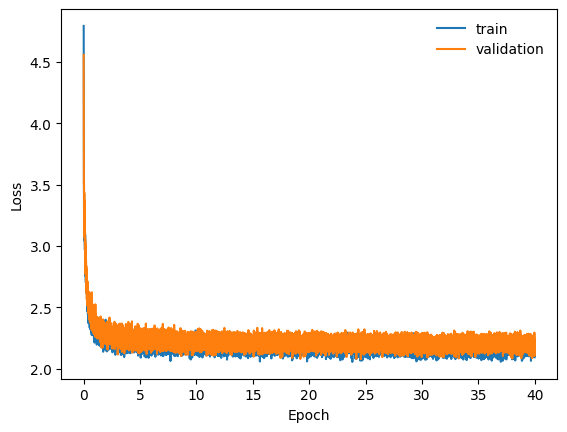

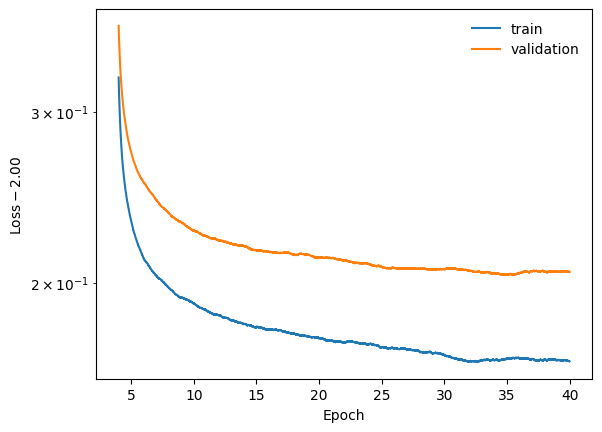

In [5]:
snapshot_number = 33
model_dir = "{}/transformer1_{:d}_ep40_bs512_w0.02".format(base_dir, snapshot_number)
output_dir = "{}/figures".format(model_dir)
os.makedirs(output_dir, exist_ok=True)

### load parameters
with open("{}/args.json".format(model_dir), "r") as f:
    opt = json.load(f, object_hook=lambda d: argparse.Namespace(**d))
    opt.norm_param_dict = namespace_to_dict(opt.norm_param_dict)
print("opt: ", opt)

max_ids = np.loadtxt("../dataset/param_files/max_nbin20_{:d}.txt".format(snapshot_number))
max_ids = ( max_ids * opt.num_features_out ).astype(int)
max_ids = torch.tensor(max_ids).to(device)

### load model
model = transformer_model(opt)
model.load_state_dict(torch.load("{}/model.pth".format(model_dir), map_location=device))
model.to(device)

model.eval()
print(model)


### plot loss 
loss = np.loadtxt("{}/log.txt".format(model_dir), comments="#")
plt.figure()
x = loss[:,0]
plt.plot(x, loss[:,1], label="train")
#plot_running_mean(x, loss[:,2], 100, label="validation")
plt.plot(x, loss[:,2], label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(frameon=False)

plt.figure()
dx = min(int(len(x)/10), 10000)
plt.xlabel("Epoch")
plt.yscale("log")
ymin = 2
plt.ylabel(r"${\rm Loss} - %.2f$"%(ymin))

plot_running_mean(x, loss[:,1], dx, show_diff=True, label="train", ymin=ymin)
plot_running_mean(x, loss[:,2], dx, show_diff=True, label="validation", ymin=ymin)
#plt.grid()
plt.legend(frameon=False)

print("Final mean validation loss: {:.3f}".format(loss[-100:,2].mean()))


# Generate galaxies for test halo data

In [6]:
### True data ###
data_path = "../dataset/TNG300-1/TNG300-1_{:d}.h5".format(snapshot_number)

ndata = None
dataset_true = MyDataset(data_path, input_features=opt.input_features, output_features=opt.output_features, norm_param_dict=opt.norm_param_dict, max_length=opt.max_length, ndata=ndata, exclude_ratio=opt.exclude_ratio, use_excluded_region=True)
#dataset_true = MyDataset(data_path, input_features=opt.input_features, output_features=opt.output_features, norm_param_dict=opt.norm_param_dict, max_length=opt.max_length, ndata=ndata, exclude_ratio=0, use_excluded_region=False)

x_true = dataset_true.x
y_true = dataset_true.y_padded
mask = dataset_true.mask
print("Number of halos: ", len(x_true))
print("Number of galaxies: ", mask.sum().item())

### set threshold
#threshold = 1. / opt.num_features_out
threshold = normalize(1e-3, opt.output_features[0], opt.norm_param_dict)
bin_of_threshold = int(threshold * opt.num_features_out)
print("threshold: ", threshold)
print("bin of threshold: ", bin_of_threshold)

prob_threshold = 1e-5 # p = 0 if p < prob_threshold

### model output ###
generated = []

batch_size = opt.batch_size
batch_size = 1024
num_batch = (len(x_true) + batch_size - 1) // batch_size

count = 0
for i in tqdm(range(num_batch)):
    tmp = x_true[count:count+batch_size].to(device)
    with torch.no_grad():
        gen, _ = model.generate(tmp, stop_criterion=threshold, prob_threshold=prob_threshold, max_ids=max_ids) 
    generated.append(gen)
    count += batch_size
    
generated = torch.cat(generated, dim=0)

x_true = x_true[:,0].detach().cpu().numpy() # (batch, num_condition) -> (batch,)
y_true = y_true.detach().cpu().numpy()
generated = generated.detach().cpu().numpy()


0it [00:00, ?it/s]

# Loading halo data from ../dataset/TNG300-1/TNG300-1_33.h5
# Using excluded region of size (0.5 * BoxSize)^3


1it [00:05,  5.05s/it]


Number of halos:  38746
Number of galaxies:  589632
threshold:  0.03225806451612906
bin of threshold:  3


100%|██████████| 38/38 [00:02<00:00, 14.96it/s]


In [7]:
### calculate length ###
threshold = normalize(1e-3, opt.output_features[0], opt.norm_param_dict)
length_true = calc_length(y_true, threshold)
length_generated = calc_length(generated, threshold)

threshold01 = normalize(0.1, opt.output_features[0], opt.norm_param_dict)
ngal_true_th01 = calc_ngal_th(y_true, threshold=threshold01)
ngal_generated_th01 = calc_ngal_th(generated, threshold=threshold01)

threshold1 = normalize(1., opt.output_features[0], opt.norm_param_dict)
ngal_true_th1 = calc_ngal_th(y_true, threshold=threshold1)
ngal_generated_th1 = calc_ngal_th(generated, threshold=threshold1)

threshold10 = normalize(10, opt.output_features[0], opt.norm_param_dict)
ngal_true_th10 = calc_ngal_th(y_true, threshold=threshold10)
ngal_generated_th10 = calc_ngal_th(generated, threshold=threshold10)

### binning ###
nbins = 20
xbins = np.linspace(0, 1, nbins+1)
xbins_physical_unit_in = normalize(np.repeat(xbins[:,None], len(opt.input_features), axis=1), opt.input_features, opt.norm_param_dict, inverse=True, convert=False)  # (num_bins, num_params)
xbins_physical_unit_out = normalize(np.repeat(xbins[:,None], len(opt.output_features), axis=1), opt.output_features, opt.norm_param_dict, inverse=True, convert=False)

xbin_indices_true = np.digitize(x_true, xbins) - 1 # (num_samples,)
ybin_indices_true = np.digitize(y_true, xbins) - 1 # (num_samples, seq_length, num_params)
ybin_indices_generated = np.digitize(generated, xbins) - 1 # (num_samples, seq_length, num_params)

# Total SFR of halo
mask = np.arange(opt.max_length) < length_true[:,None]
output_masked = normalize(y_true[...,0], opt.output_features[0], opt.norm_param_dict, inverse=True) * mask
y_true_sat_tot = np.sum(output_masked[:,1:], axis=1)
y_true_tot = np.sum(output_masked, axis=1)

mask = np.arange(opt.max_length) < length_generated[:,None]
output_masked = normalize(generated[...,0], opt.output_features[0], opt.norm_param_dict, inverse=True) * mask
y_generated_sat_tot = np.sum(output_masked[:,1:], axis=1)
y_generated_tot = np.sum(output_masked, axis=1)

y_true_sat_tot = np.log10(y_true_sat_tot) # (num_samples,)
y_true_tot = np.log10(y_true_tot) # (num_samples,)
y_generated_sat_tot = np.log10(y_generated_sat_tot) # (num_samples,)
y_generated_tot = np.log10(y_generated_tot) # (num_samples,)

1250084087.py:39: RuntimeWarning: divide by zero encountered in log10
1250084087.py:41: RuntimeWarning: divide by zero encountered in log10


# Plot Histogram

Saved figure to ../scripts/runs/output_transformer/transformer1_33_ep40_bs512_w0.02/figures/hist_length.pdf
Saved figure to ../scripts/runs/output_transformer/transformer1_33_ep40_bs512_w0.02/figures/hist_length_th.pdf
Saved figure to ../scripts/runs/output_transformer/transformer1_33_ep40_bs512_w0.02/figures/hist_length_sfr_bin.png


966654004.py:23: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


Saved figure to ../scripts/runs/output_transformer/transformer1_33_ep40_bs512_w0.02/figures/hist_total_sfr.pdf


966654004.py:23: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


Saved figure to ../scripts/runs/output_transformer/transformer1_33_ep40_bs512_w0.02/figures/hist_central_sfr_logm0.pdf
Saved figure to ../scripts/runs/output_transformer/transformer1_33_ep40_bs512_w0.02/figures/hist_central_sfr_logm5.pdf


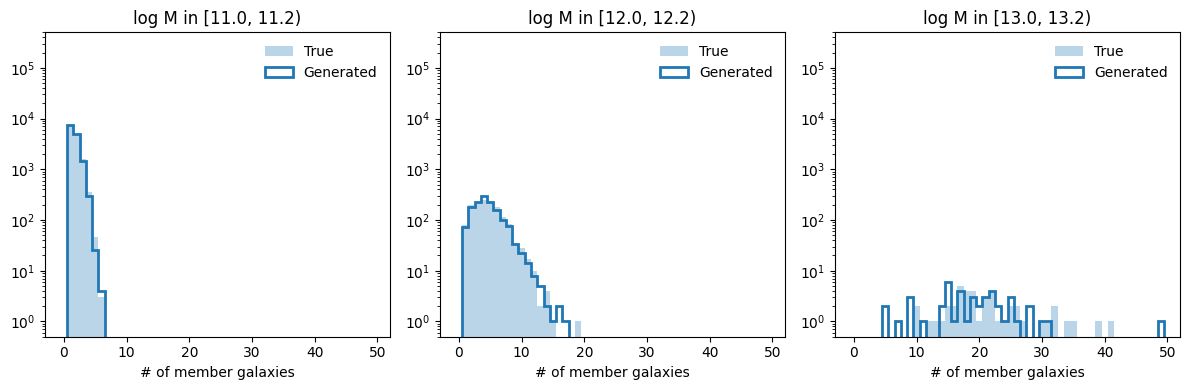

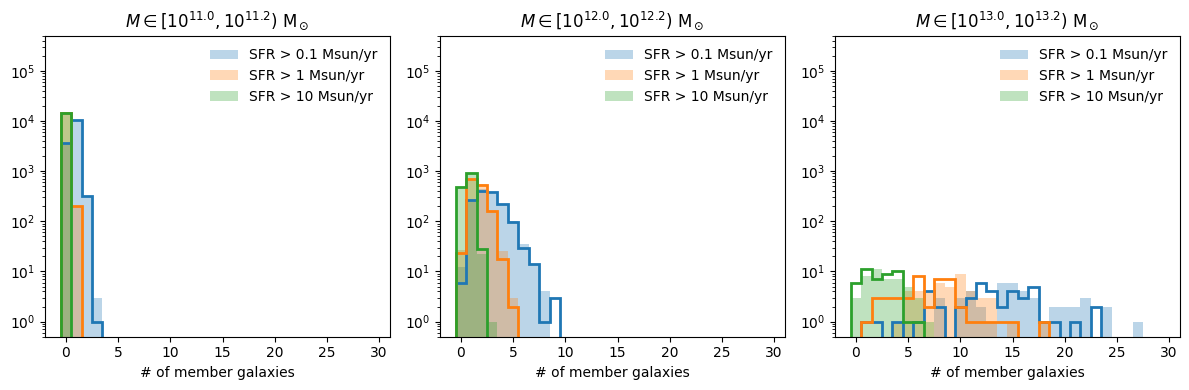

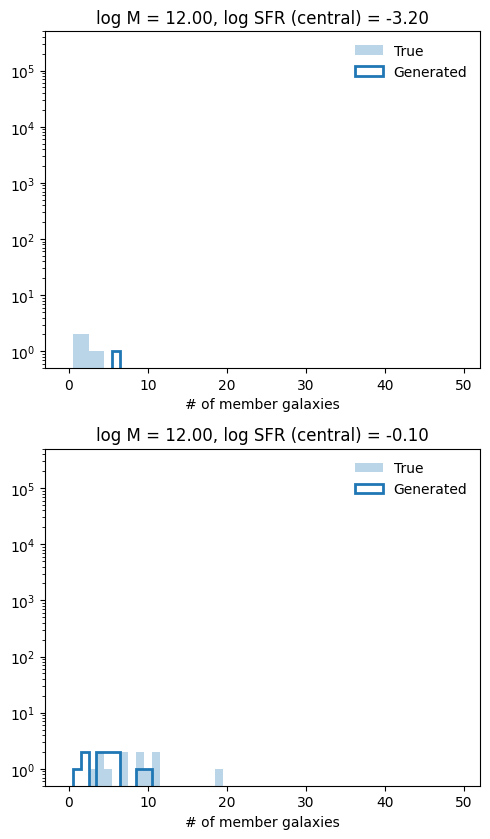

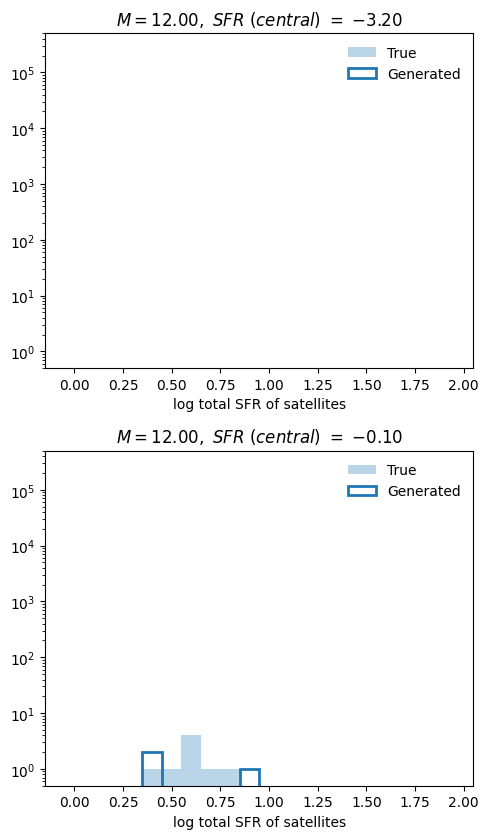

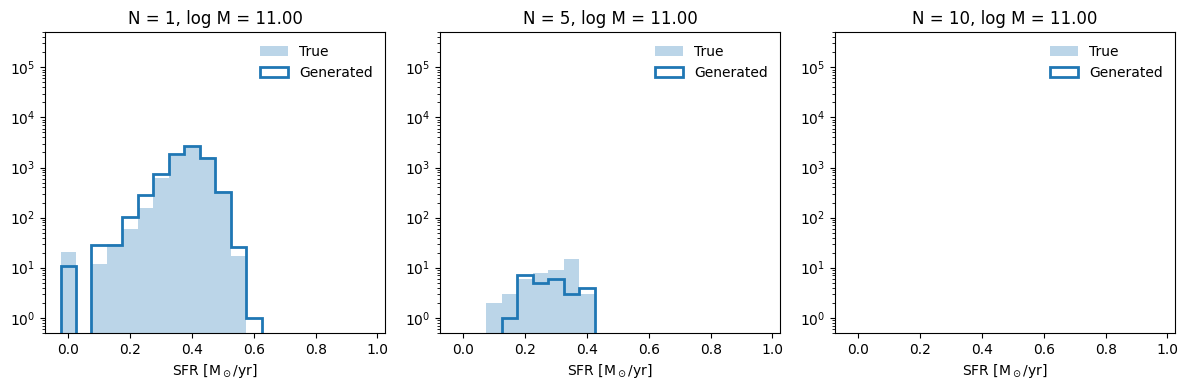

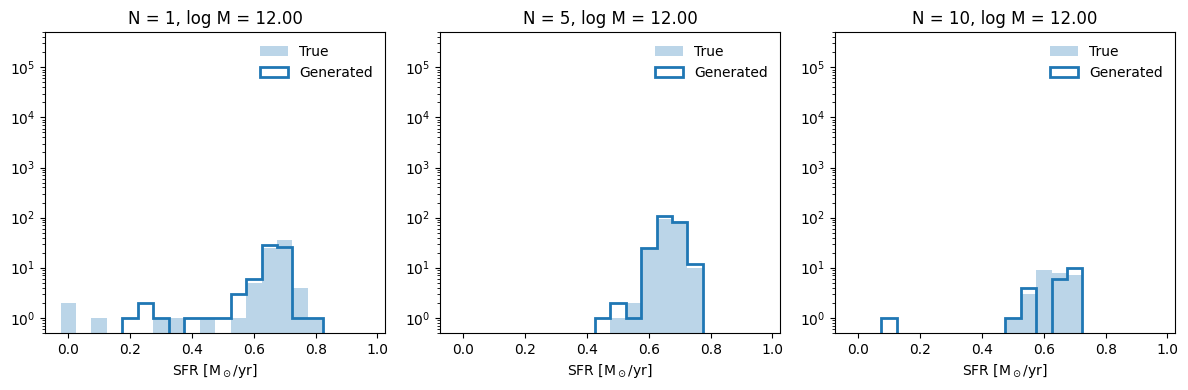

In [47]:
### Histograms 
density = False 
#density = True

def show_length_hist(length_list, indices=None, panel_id=(1,1,1), title=None, label_list=["True", "Generated"], xlabel="# of member galaxies", density=density, bin_range=(0,opt.max_length), bins=opt.max_length):

    if indices is None:
        indices = slice(None)
    if not isinstance(indices, (list)):
        indices = [ indices ] * len(length_list)
    if not isinstance(label_list, list):
        label_list = [label_list] * len(length_list)

    plt.subplot(*panel_id)
    plt.title(title)

    for i in range(len(length_list)):
        if i%2 == 0:
            n, bins, patches = plt.hist(length_list[i][indices[i]], range=bin_range, bins=bins, alpha=0.3, density=density, label=label_list[i], align="left")
        else:
            plt.hist(length_list[i][indices[i]], range=bin_range, bins=bins, alpha=1, density=density, label=label_list[i], align="left", histtype="step", color=patches[0].get_facecolor(), linewidth=2)

    plt.yscale("log")
    plt.xlabel(xlabel)
    if density:
        plt.ylim([1e-3, 1.5])
    else:
        plt.ylim([5e-1, 5e5])
    plt.legend(frameon=False)

### Length in bins of log M
list_to_show = [0, 5, 10]
plt.figure(figsize=(len(list_to_show)*4, 4))
for count, i in enumerate(list_to_show):
    indices = np.where(xbin_indices_true == i)[0]
    title = "log M in [{:.1f}, {:.1f})".format(xbins_physical_unit_in[i,0], xbins_physical_unit_in[i+1,0])
    show_length_hist([length_true, length_generated], indices=indices, panel_id=(1,len(list_to_show),count+1), title=title, density=density)

fout = f"{output_dir}/hist_length.pdf"
my_savefig(fout)

### Length with SFR > th in bins of log M
list_to_show = [0, 5, 10]
plt.figure(figsize=(len(list_to_show)*4, 4))
l_list = [ngal_true_th01, ngal_generated_th01, ngal_true_th1, ngal_generated_th1, ngal_true_th10, ngal_generated_th10]
label_list = ["SFR > 0.1 Msun/yr", "", 
              "SFR > 1 Msun/yr", "", 
              "SFR > 10 Msun/yr", ""]
#bin_ranges = [(0, 8), (0, 13), (0, 40)]
bin_ranges = [(0, 30), (0, 30), (0, 30)]
for count, i in enumerate(list_to_show):
    indices = np.where(xbin_indices_true == i)[0]
    title = r"$M \in [10^{%.1f}, 10^{%.1f})\ \rm M_\odot$" % (xbins_physical_unit_in[i,0], xbins_physical_unit_in[i+1,0])

    show_length_hist(l_list, indices=indices, panel_id=(1,len(list_to_show),count+1), title=title, label_list=label_list, density=density, bin_range=bin_ranges[count], bins=bin_ranges[count][1])
fout = f"{output_dir}/hist_length_th.pdf"
my_savefig(fout)


### length in bins in (log M, log SFR)
list_to_show = [5]
y_list_to_show = [0, 10]
plt.figure(figsize=(len(list_to_show)*5, len(y_list_to_show)*4+0.5))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
count = 0
for i in list_to_show:
    base_mask = (xbin_indices_true == i)
    for j in y_list_to_show:
        indices = [
            np.where((ybin_indices_true[:,0,0] == j) & base_mask )[0],
            np.where((ybin_indices_generated[:,0,0] == j) & base_mask)[0]
        ]
        title = "log M = {:.2f}, log SFR (central) = {:.2f}".format(xbins_physical_unit_in[i,0], xbins_physical_unit_out[j,0])
        show_length_hist([length_true, length_generated], indices=indices, panel_id=(len(y_list_to_show),len(list_to_show),count+1), title=title, density=density)        
        count += 1

fout = f"{output_dir}/hist_length_sfr_bin.png"
my_savefig(fout)

### Total satellite SFR in bins in (log M, length)
list_to_show = [5]
y_list_to_show = [0, 10]
plt.figure(figsize=(len(list_to_show)*5, len(y_list_to_show)*4+0.5))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
count = 0
for i in list_to_show:
    base_mask = (xbin_indices_true == i)
    for j in y_list_to_show:
        indices = [
            np.where((ybin_indices_true[:,0,0] == j) & base_mask )[0],
            np.where((ybin_indices_generated[:,0,0] == j) & base_mask)[0]
        ]
        title = r"$M = {%.2f}, \ SFR\  (central)\  =\ {%.2f}$"%(xbins_physical_unit_in[i,0], xbins_physical_unit_out[j,0])
        show_length_hist([y_true_sat_tot, y_generated_sat_tot], indices=indices, panel_id=(len(y_list_to_show),len(list_to_show),count+1), title=title, density=density, bin_range=(0,2), bins=20, xlabel="log total SFR of satellites")        
        count += 1

fout = f"{output_dir}/hist_total_sfr.pdf"
my_savefig(fout)

### Central SFR in bins in (log M, length)
list_to_show = [0, 5]
length_list_to_show = [1, 5, 10]
for i_logm in list_to_show:
    base_mask = (xbin_indices_true == i_logm)
    for iparam in range(1): # only for the first parameter    
        plt.figure(figsize=(len(length_list_to_show)*4, 4))
        for count, i in enumerate(length_list_to_show):
            
            plt.subplot(1, len(length_list_to_show), count+1)
            title = "N = {:d}, log M = {:.2f}".format(i, xbins_physical_unit_in[i_logm, 0])
            indices = [
                np.where((length_true == i) & base_mask )[0],
                np.where((length_generated == i) & base_mask)[0]
            ]
            show_length_hist([y_true[:,0,iparam], generated[:,0,iparam]], indices=indices, panel_id=(1,len(length_list_to_show),count+1), title=title, density=density, bin_range=(0,1), bins=20, xlabel=param_names[iparam])   

        fout = f"{output_dir}/hist_central_sfr_logm{i_logm}.pdf" 
        my_savefig(fout)

# Mass vs X 

Saved figure to ../scripts/runs/output_transformer/transformer1_33_ep40_bs512_w0.02/figures/logm_x.pdf


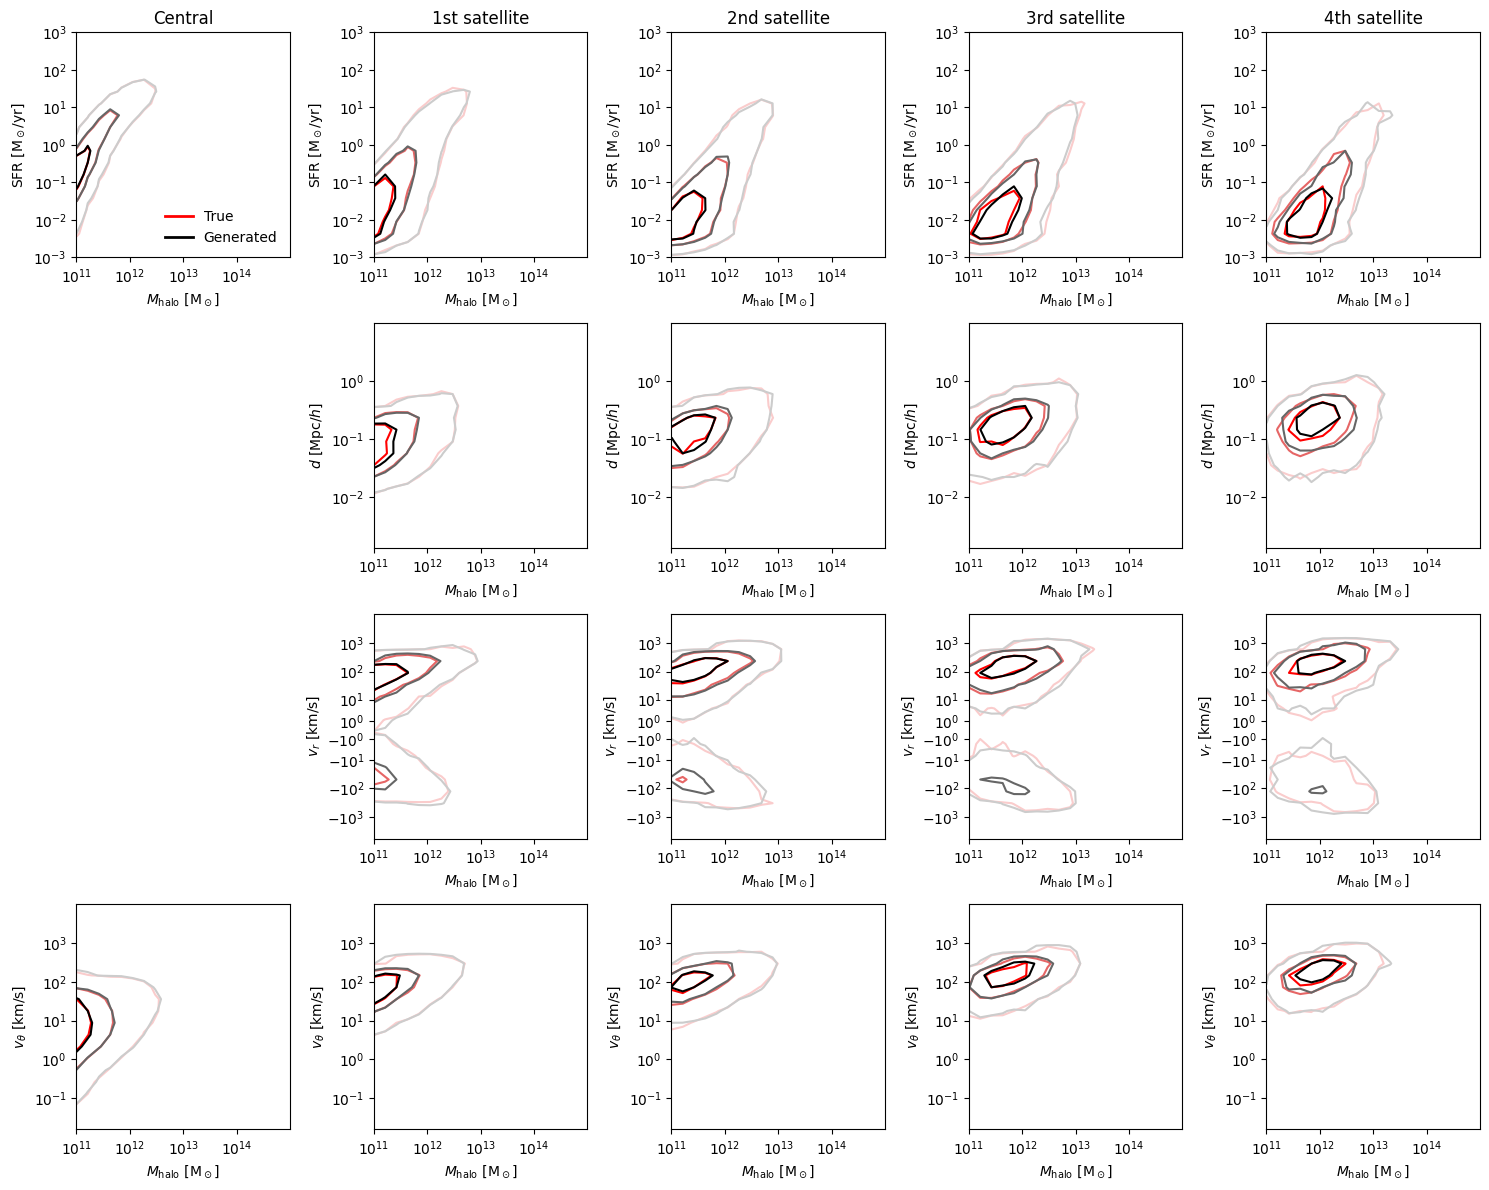

In [57]:

from matplotlib.lines import Line2D

### comparison of M-SFR relations 
show_scatter = True
show_scatter = False

show_diff = False

colors_black = [(0.8, 0.8, 0.8),(0.4, 0.4, 0.4),"black"]
colors_red = [(0.98, 0.8, 0.8),(0.9, 0.4, 0.4),"red"]

max_length_to_show = 5

def compute_contour_levels(grid_data, sigma_levels=[0.9545, 0.6827, 0.383]): #[0.9973, 0.9545, 0.6827, 0.383]
    grid_data = grid_data / np.sum(grid_data)
    grid_data_sorted = np.sort(grid_data.flatten())[::-1]
    cumsum = np.cumsum(grid_data_sorted)

    levels = [ grid_data_sorted[np.where(cumsum > sigma)[0][0]] for sigma in sigma_levels ]

    return grid_data, levels

plt.figure(figsize=(15, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
    
target_x = [1e11, 1e12, 1e13, 1e14]
tick_x = normalize( np.array(target_x), opt.input_features, opt.norm_param_dict )

for iparam in range(opt.num_features_in):
    for i in range(max_length_to_show):
        if iparam == 1 and i == 0:
            continue
        if iparam == 2 and i == 0:
            continue

        mask = length_true > i 
        xnow_true = x_true[mask]
        ynow_true = y_true[mask]
        mask = length_generated > i 
        xnow = x_true[mask]
        ynow = generated[mask]

        plt.subplot(4,5,i+1 + iparam * max_length_to_show) 
        if iparam == 0:
            if i == 0:
                plt.title("Central")
            elif i == 1:
                plt.title("1st satellite")
            elif i == 2:
                plt.title("2nd satellite")
            elif i == 3:
                plt.title("3rd satellite")
            else:
                plt.title("{:d}th satellite".format(i))  

        handle_list = []
        if show_scatter:
            plt.scatter(xnow_true, ynow_true[:,i,iparam], s=1, color="blue", alpha=0.5)
            plt.scatter(xnow, ynow[:,i,iparam], s=1, color="red", alpha=0.5)
        else:
            hist_range = [[0,1],[threshold,1]]
            extent = [0,1,threshold,1]

            hist = np.histogram2d(xnow_true, ynow_true[:,i,iparam], bins=20, range=hist_range)
            grid_data, levels = compute_contour_levels(hist[0])
            plt.contour(grid_data.T, extent=extent, colors=colors_red, levels=levels)
            handle_list.append(plt.Line2D([0], [0], color=colors_red[-1], lw=2, label="True"))
            
            hist = np.histogram2d(xnow, ynow[:,i,iparam], bins=20, range=hist_range)
            grid_data, levels = compute_contour_levels(hist[0])
            plt.contour(grid_data.T, extent=extent, colors=colors_black, levels=levels)
            handle_list.append(plt.Line2D([0], [0], color=colors_black[-1], lw=2, label="Generated"))

        if iparam == 0:
            target_y = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1e3]
        elif iparam == 1:
            target_y = [1e-2, 1e-1, 1]
        elif iparam == 2:
            target_y = [-1e3, -1e2, -1e1, -1, 1, 10, 100, 1e3]
        elif iparam == 3:
            target_y = [1e-1, 1, 10, 100, 1000]

        if iparam == 2:
            tick_y = normalize(np.array(target_y), opt.output_features[iparam], opt.norm_param_dict)
        else:
            tick_y = normalize(np.array(target_y), opt.output_features[iparam], opt.norm_param_dict)

        target_y_labels = [r"$10^{%.0f}$"%(np.log10(t)) if t > 0 else r"$-10^{%.0f}$"%(np.log10(np.abs(t))) for t in target_y]
        plt.yticks(tick_y, target_y_labels)
        plt.ylabel(param_names[iparam])

        plt.xticks(tick_x, [r"$10^{%.0f}$"%(np.log10(t)) for t in target_x])
        plt.xlabel(r"$M_{\rm halo}\ \rm [M_\odot]$")

        if i == 0 and iparam == 0:
            plt.legend(handles=handle_list, loc="lower right", frameon=False)

    if show_scatter:
        break

fout = f"{output_dir}/logm_x.pdf"
my_savefig(fout)

1284353974.py:78: RuntimeWarning: divide by zero encountered in log10
1284353974.py:78: RuntimeWarning: divide by zero encountered in log10
1284353974.py:78: RuntimeWarning: divide by zero encountered in log10


Saved figure to ../scripts/runs/output_transformer/transformer1_33_ep40_bs512_w0.02/figures/hist_x.pdf


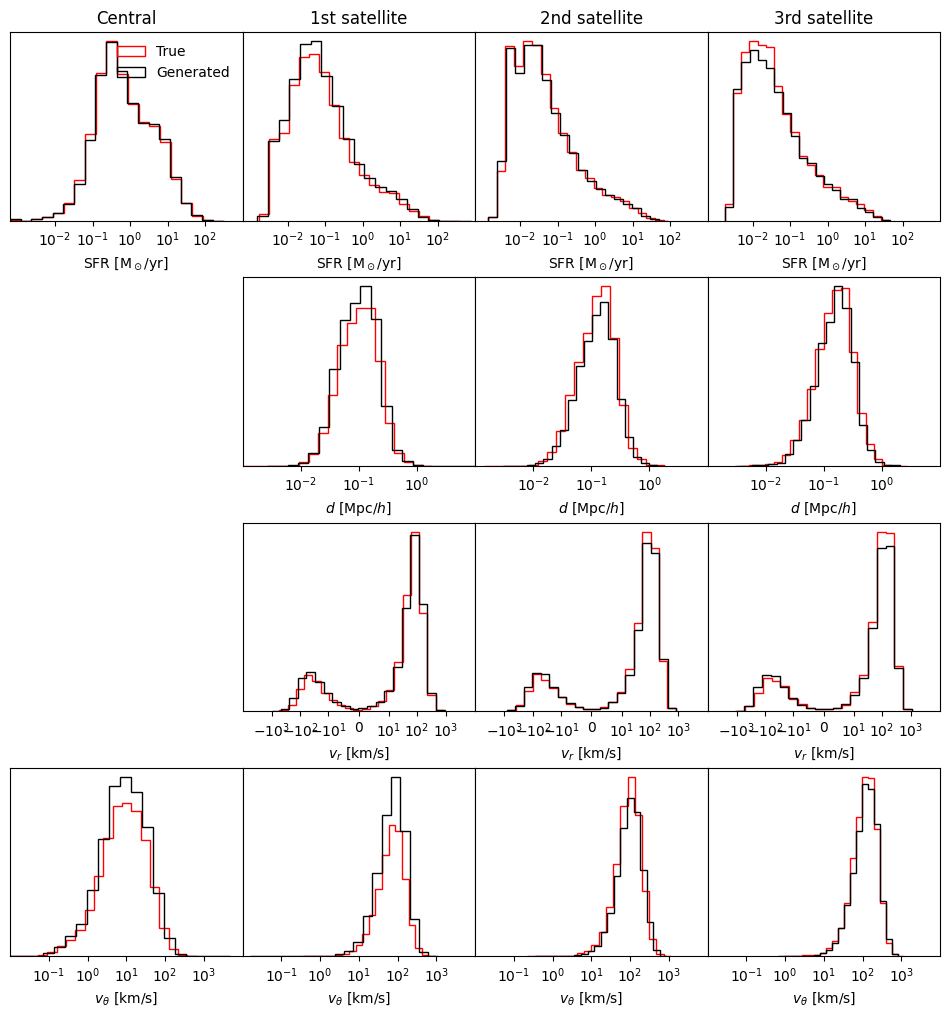

In [72]:

from matplotlib.lines import Line2D

### comparison of M-SFR relations 
show_scatter = True
show_scatter = False

show_diff = False

colors_black = [(0.8, 0.8, 0.8),(0.4, 0.4, 0.4),"black"]
colors_red = [(0.98, 0.8, 0.8),(0.9, 0.4, 0.4),"red"]

max_length_to_show = 4

def compute_contour_levels(grid_data, sigma_levels=[0.9545, 0.6827, 0.383]): #[0.9973, 0.9545, 0.6827, 0.383]
    grid_data = grid_data / np.sum(grid_data)
    grid_data_sorted = np.sort(grid_data.flatten())[::-1]
    cumsum = np.cumsum(grid_data_sorted)

    levels = [ grid_data_sorted[np.where(cumsum > sigma)[0][0]] for sigma in sigma_levels ]

    return grid_data, levels

plt.figure(figsize=(3*max_length_to_show, 3*opt.num_features_in))
plt.subplots_adjust(wspace=0, hspace=0.3)
    
target_x = [1e11, 1e12, 1e13, 1e14]
tick_x = normalize( np.array(target_x), opt.input_features, opt.norm_param_dict )

for iparam in range(opt.num_features_in):
    for i in range(max_length_to_show):
        if iparam == 1 and i == 0:
            continue
        if iparam == 2 and i == 0:
            continue

        mask = length_true > i 
        xnow_true = x_true[mask]
        ynow_true = y_true[mask]
        mask = length_generated > i 
        xnow = x_true[mask]
        ynow = generated[mask]

        plt.subplot(opt.num_features_in,max_length_to_show,i+1 + iparam * max_length_to_show) 
        if iparam == 0:
            if i == 0:
                plt.title("Central")
            elif i == 1:
                plt.title("1st satellite")
            elif i == 2:
                plt.title("2nd satellite")
            elif i == 3:
                plt.title("3rd satellite")
            else:
                plt.title("{:d}th satellite".format(i))  

        handle_list = []
    
        hist_range = [0,1]
        extent = [0,1,threshold,1]

        plt.hist(ynow_true[:,i,iparam], bins=20, color=colors_red[-1], histtype="step", label="True") #, density=True)
        plt.hist(ynow[:,i,iparam], bins=20, color=colors_black[-1], histtype="step", label="Generated") #, density=True)
        
        if iparam == 0:
            target_y = [1e-2, 1e-1, 1, 10, 100]
        elif iparam == 1:
            target_y = [1e-2, 1e-1, 1]
        elif iparam == 2:
            target_y = [ -1e3, -1e2, -1e1, 0, 10, 1e2, 1e3]
        elif iparam == 3:
            target_y = [1e-1, 1, 10, 100, 1000]

        if iparam == 2:
            tick_y = normalize(np.array(target_y), opt.output_features[iparam], opt.norm_param_dict)
        else:
            tick_y = normalize(np.array(target_y), opt.output_features[iparam], opt.norm_param_dict)

        target_y_labels = [r"$10^{%.0f}$"%(np.log10(t)) if t > 0 else r"$-10^{%.0f}$"%(np.log10(np.abs(t))) for t in target_y]
        target_y_labels = [ "0" if target_y[i] == 0 else target_y_labels[i] for i in range(len(target_y_labels)) ]
        plt.xticks(tick_y, target_y_labels)
        plt.xlabel(param_names[iparam])
        plt.yticks([])

        plt.xlim([0,1])

        if i == 0 and iparam == 0:
            plt.legend(frameon=False)

    if show_scatter:
        break

fout = f"{output_dir}/hist_x.pdf"
my_savefig(fout, tight_layout=False)

# Joint probability distribution

Saved figure to ../scripts/runs/output_transformer/transformer1_33_ep40_bs512_w0.02/figures/corner_0.pdf
Saved figure to ../scripts/runs/output_transformer/transformer1_33_ep40_bs512_w0.02/figures/corner_1.pdf


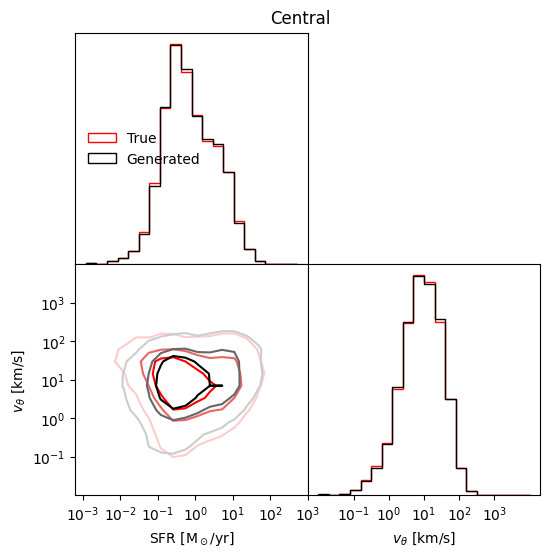

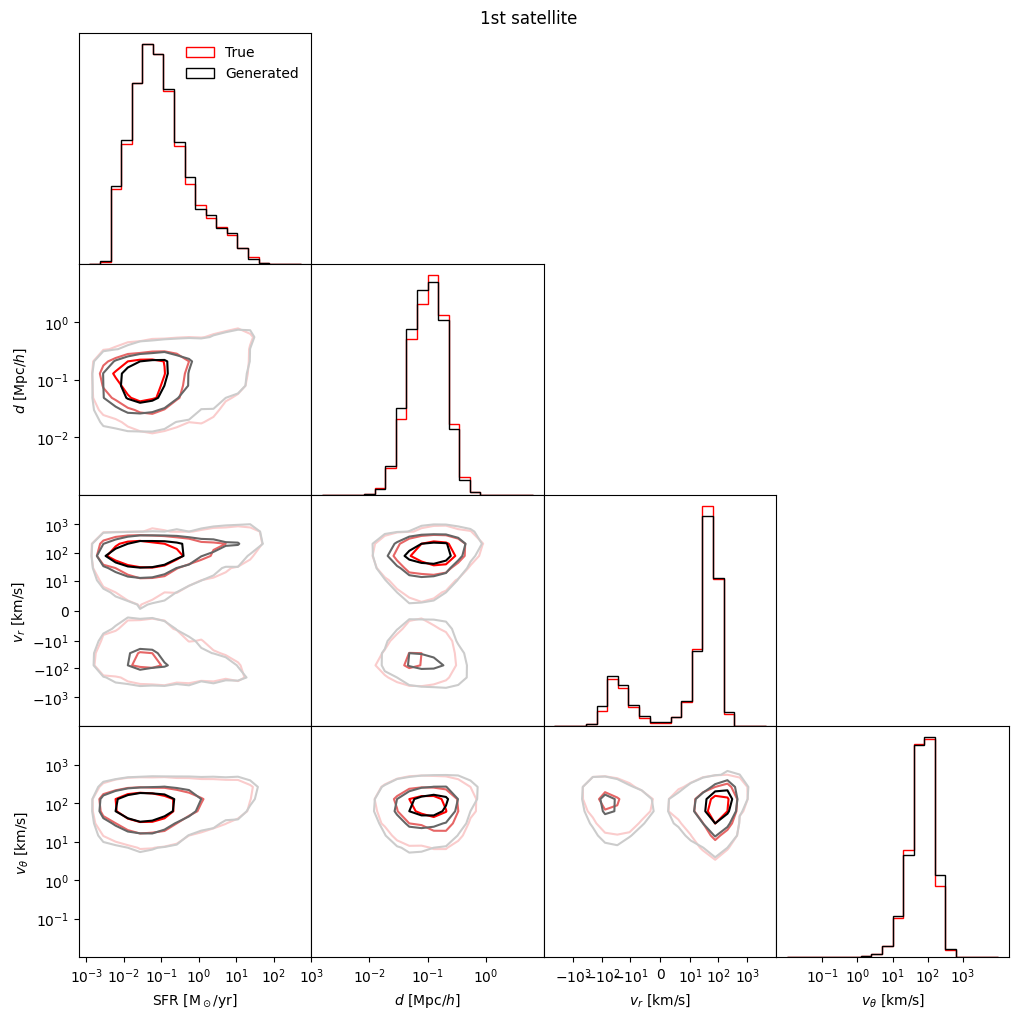

In [35]:
from matplotlib.lines import Line2D

### comparison of M-SFR relations 
show_scatter = True
show_scatter = False

show_diff = False

colors_black = [(0.8, 0.8, 0.8),(0.4, 0.4, 0.4),"black"]
colors_red = [(0.98, 0.8, 0.8),(0.9, 0.4, 0.4),"red"]

max_length_to_show = 2

#halo_mask = (xbin_indices_true == 10)
halo_mask = (xbin_indices_true > -1)

def compute_contour_levels(grid_data, sigma_levels=[0.9545, 0.6827, 0.383]): #[0.9973, 0.9545, 0.6827, 0.383]
    grid_data = grid_data / np.sum(grid_data)
    grid_data_sorted = np.sort(grid_data.flatten())[::-1]
    cumsum = np.cumsum(grid_data_sorted)

    levels = [ grid_data_sorted[np.where(cumsum > sigma)[0][0]] for sigma in sigma_levels ]

    return grid_data, levels

def show_ticks(iparam, x_or_y="x"):
    if iparam == 0:
        target_y = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1e3]
    elif iparam == 1:
        target_y = [1e-2, 1e-1, 1]
    elif iparam == 2:
        target_y = [-1e3, -1e2, -1e1, 0, 10, 100, 1e3]
    elif iparam == 3:
        target_y = [1e-1, 1, 10, 100, 1000]

    if iparam == 2:
        tick_values = normalize(np.array(target_y), opt.output_features[iparam], opt.norm_param_dict)
    else:
        tick_values = normalize(np.array(target_y), opt.output_features[iparam], opt.norm_param_dict)

    tick_labels = [
        "0" if t == 0
        else (r"$10^{%.0f}$" % np.log10(t)) if t >= 0 
        else (r"$-10^{%.0f}$" % np.log10(abs(t)))
        for t in target_y
    ]

    if x_or_y == "x":
        plt.xticks(tick_values, tick_labels)
        plt.xlabel(param_names[iparam])
    else:
        plt.yticks(tick_values, tick_labels)
        plt.ylabel(param_names[iparam])

    
target_x = [1e11, 1e12, 1e13, 1e14]
tick_x = normalize( np.array(target_x), opt.input_features, opt.norm_param_dict )

for i in range(max_length_to_show):
    if i == 0:
        nrows = ncols = 2
    else:
        nrows = ncols = 4

    fig = plt.figure(figsize=(3*ncols,3*nrows))
    plt.subplots_adjust(wspace=0, hspace=0)
    if i == 0:
        plt.suptitle("Central", y=0.92)
    elif i == 1:
        plt.suptitle("1st satellite", y=0.9)

    mask = halo_mask & (length_true > i)
    ynow_true = y_true[mask]
    
    mask = halo_mask & (length_generated > i) 
    ynow = generated[mask]

    for iparam in range(opt.num_features_in):
        if i == 0:
            if iparam == 1 or iparam == 2:
                continue
            else:
                plt.subplot(nrows, ncols, 1 + min(iparam, 1) * 3)
        else:
            plt.subplot(nrows, ncols, 1 + iparam * (ncols+1))
    
        plt.hist(ynow_true[:,i, iparam], bins=20, range=(0,1), histtype="step", color=colors_red[-1], label="True")
        plt.hist(ynow[:,i, iparam], bins=20, range=(0,1), histtype="step", color=colors_black[-1], label="Generated")
        plt.yticks([])

        if iparam == 0:
            plt.legend(frameon=False)

        if iparam >= ncols - 1:
            show_ticks(iparam, "x")
        else:
            plt.xticks([])

        for iparam2 in range(opt.num_features_in):

            if iparam2 <= iparam:
                continue

            if i == 0:
                if (iparam == 1 or iparam2 == 1 or iparam == 2 or iparam2 == 2):
                    continue
                else:
                    plt.subplot(nrows, ncols, 3)
            else:           
                ax = plt.subplot(nrows, ncols, 1 + iparam + ncols * iparam2)
            
            handle_list = []
            if show_scatter:
                plt.scatter(ynow_true[:,i,iparam], ynow_true[:,i,iparam2], s=1, color="blue", alpha=0.5)
                plt.scatter(ynow[:,i,iparam], ynow[:,i,iparam2], s=1, color="red", alpha=0.5)
            else:
                hist_range = [[0,1],[0,1]]
                extent = [0,1,0,1]

                hist = np.histogram2d(ynow_true[:,i,iparam], ynow_true[:,i,iparam2], bins=20, range=hist_range)
                grid_data, levels = compute_contour_levels(hist[0])
                plt.contour(grid_data.T, extent=extent, colors=colors_red, levels=levels)
                handle_list.append(plt.Line2D([0], [0], color=colors_red[-1], lw=2, label="True"))
                
                hist = np.histogram2d(ynow[:,i,iparam], ynow[:,i,iparam2], bins=20, range=hist_range)
                grid_data, levels = compute_contour_levels(hist[0])
                plt.contour(grid_data.T, extent=extent, colors=colors_black, levels=levels)
                handle_list.append(plt.Line2D([0], [0], color=colors_black[-1], lw=2, label="Generated"))

            if iparam2 >= nrows - 1:
                show_ticks(iparam, "x")
            else:
                plt.xticks([])
            
            if iparam == 0:
                show_ticks(iparam2, "y")
            else:
                plt.yticks([])

            if count == 0:
                plt.legend(handles=handle_list, loc="lower left", frameon=False)
            count += 1
        if show_scatter:
            break


    fout = f"{output_dir}/corner_{i}.pdf"
    my_savefig(fout, tight_layout=False)

# Correlation between galaxies

Saved figure to ../scripts/runs/output_transformer/transformer1_33_ep40_bs512_w0.02/figures/contour_0_1_logm11.0.pdf
Saved figure to ../scripts/runs/output_transformer/transformer1_33_ep40_bs512_w0.02/figures/contour_0_1_logm12.0.pdf
Saved figure to ../scripts/runs/output_transformer/transformer1_33_ep40_bs512_w0.02/figures/contour_0_1_logm12.4.pdf
Saved figure to ../scripts/runs/output_transformer/transformer1_33_ep40_bs512_w0.02/figures/contour_0_1_logm13.0.pdf


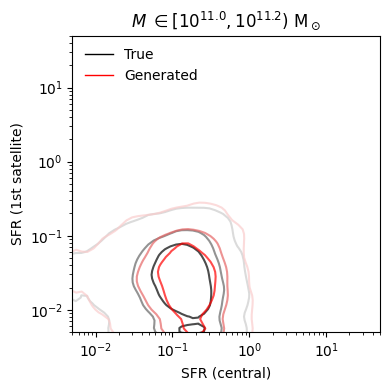

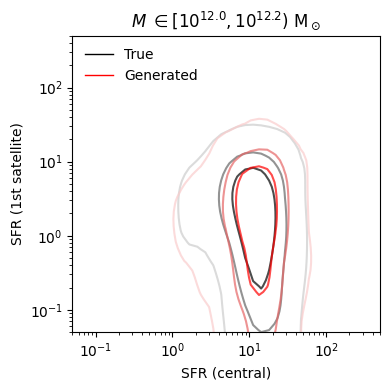

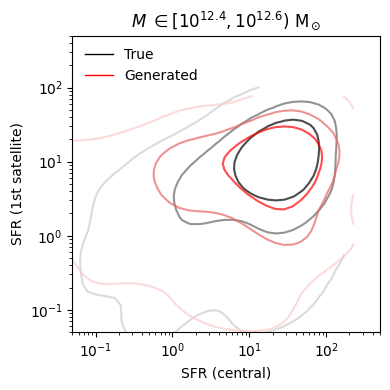

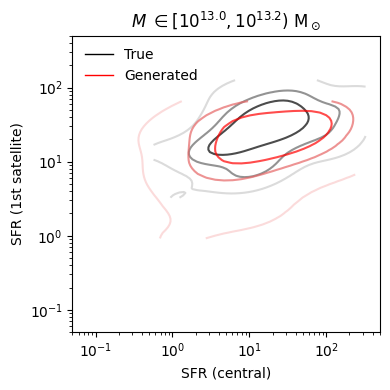

In [84]:
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde
import matplotlib.cm as cm

def plot_contour(y1, y2, colors, label=None, nbins=50):
    logy1 = np.log10(y1)
    logy2 = np.log10(y2)
    values = np.vstack([logy1, logy2])
    kde = gaussian_kde(values)

    xgrid = np.linspace(logy1.min(), logy1.max(), nbins)
    ygrid = np.linspace(logy2.min(), logy2.max(), nbins)
    X, Y = np.meshgrid(xgrid, ygrid)
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = kde(positions).reshape(X.shape)

    Z_flat = Z.flatten()
    Z_sorted = np.sort(Z_flat)[::-1]  
    cumsum = np.cumsum(Z_sorted)
    cumsum /= cumsum[-1]  

    levels = []
    for target in [0.9545, 0.6827, 0.383]: #[0.9973, 0.9545, 0.6827, 0.383]:
        idx = np.searchsorted(cumsum, target)
        levels.append(Z_sorted[idx])

    contour = plt.contour(10 ** X, 10 ** Y, Z, levels=levels, colors=colors, alpha=0.7)

    return Line2D([0], [0], color=colors[-1], label=label, lw=1)
    
colors_black = [(0.8, 0.8, 0.8),(0.4, 0.4, 0.4),"black"]
colors_red = [(0.98, 0.8, 0.8),(0.9, 0.4, 0.4),"red"]

_nbins = 20
_xbins = np.linspace(0, 1, _nbins+1)
_xbins_physical_unit = normalize(np.repeat(_xbins[:,None], len(opt.input_features), axis=-1), opt.input_features, opt.norm_param_dict, inverse=True, convert=False)

_xbin_indices_true = np.digitize(x_true, _xbins) - 1 # (num_samples,)

for i in [0, 5, 7, 10]: #[5,7,9]:
    i0 = 0
    i1 = 1
    if i < 5:
        xlim = (5e-3, 5e1)
    else:
        xlim = (5e-2, 5e2)

    handle_list = []
    plt.figure(figsize=(4,4))

    #plt.title("log M in [{:.1f}, {:.1f})".format(xbins_physical_unit[i,0], xbins_physical_unit[i+1,0]))
    plt.title(r"$M\ \in [10^{%.1f}, 10^{%.1f})\ \rm  M_\odot$" % (_xbins_physical_unit[i,0], _xbins_physical_unit[i+1,0]))
    
    mask = (_xbin_indices_true == i) & (length_true > max(i0, i1))
    y1now = normalize(y_true[mask][:,i0,0], opt.output_features[0], opt.norm_param_dict, inverse=True)
    y2now = normalize(y_true[mask][:,i1,0], opt.output_features[0], opt.norm_param_dict, inverse=True)

    line_label = plot_contour(y1now, y2now, colors=colors_black, label="True")
    handle_list.append(line_label)

    mask = (_xbin_indices_true == i) & (length_generated > max(i0, i1))
    y1now = normalize(generated[mask][:,i0,0], opt.output_features[0], opt.norm_param_dict, inverse=True)
    y2now = normalize(generated[mask][:,i1,0], opt.output_features[0], opt.norm_param_dict, inverse=True)

    line_label = plot_contour(y1now, y2now, colors=colors_red, label="Generated")
    handle_list.append(line_label)

    plt.legend(handles=handle_list, loc="upper left", frameon=False)

    plt.xlim(xlim)
    plt.ylim(xlim)
    
    plt.xscale("log")
    plt.yscale("log")
    plt.ylabel("SFR (1st satellite)")
    
    plt.xlabel("SFR (central)")
    
    my_savefig("{}/contour_0_1_logm{:.1f}.pdf".format(output_dir, _xbins_physical_unit[i,0]))

In [20]:
import ot

def w1_emd(X: np.ndarray, Y: np.ndarray) -> float:
    X = np.asarray(X, dtype=float)
    Y = np.asarray(Y, dtype=float)
    n, m = X.shape[0], Y.shape[0]

    # Uniform weights
    a = np.full(n, 1.0/n)
    b = np.full(m, 1.0/m)

    # dist
    C = ot.dist(X, Y, metric='euclidean')  # 形状 (n, m)

    # minimum average cost
    w1 = ot.emd2(a, b, C)
    return float(w1)


colors_black = [(0.8, 0.8, 0.8),(0.4, 0.4, 0.4),"black"]
colors_red = [(0.98, 0.8, 0.8),(0.9, 0.4, 0.4),"red"]

_nbins = 20
_xbins = np.linspace(0, 1, _nbins+1)
_xbins_physical_unit = normalize(np.repeat(_xbins[:,None], len(opt.input_features), axis=-1), opt.input_features, opt.norm_param_dict, inverse=True, convert=False)

_xbin_indices_true = np.digitize(x_true, _xbins) - 1 # (num_samples,)

M_list = []
w_list = []
w_ref_list = []
w_ref_2_list = []
for i in [7]:
    i0 = 0
    i1 = 1
    if i < 5:
        xlim = (5e-3, 5e1)
    else:
        xlim = (5e-2, 5e2)

    handle_list = []
    
    title = "M: [10^{%.1f}, 10^{%.1f})" % (_xbins_physical_unit[i,0], _xbins_physical_unit[i+1,0])
    
    mask = (_xbin_indices_true == i) & (length_true > max(i0, i1))
    ynow = y_true[mask][:,[i0,i1],0]
    
    mask = (_xbin_indices_true == i) & (length_generated > max(i0, i1))
    ynow_generated = generated[mask][:,[i0,i1],0]

    if len(ynow) > 0 and len(ynow_generated) > 0:

        w = w1_emd(ynow, ynow_generated)

        rng = np.random.default_rng(12345)

        ynow_shuffled = ynow_generated.copy()
        rng.shuffle(ynow_shuffled[:,1])
        w_ref = w1_emd(ynow, ynow_shuffled) 

        ynow_shuffled = ynow.copy()
        rng.shuffle(ynow_shuffled[:,1])
        w_ref_2 = w1_emd(ynow, ynow_shuffled)
        
        print(w, w_ref, w_ref_2)

0.02377431405453808 0.038095063873166315 0.03564086593449987


In [9]:
mask = np.arange(opt.max_length) < length_true[:,None]
Pshot_true = normalize( y_true[:,:,0], opt.output_features[0], opt.norm_param_dict, inverse=True) ** 2
Pshot_true = ( Pshot_true * mask ).sum()

mask = np.arange(opt.max_length) < length_generated[:,None]
Pshot_generated = normalize( generated[:,:,0], opt.output_features[0], opt.norm_param_dict, inverse=True) ** 2
Pshot_generated = ( Pshot_generated * mask ).sum()

print("Pshot (True): ", Pshot_true)
print("Pshot (Generated): ", Pshot_generated)
print("Pshot ratio: ", Pshot_generated / Pshot_true)

Pshot (True):  33237453.203944724
Pshot (Generated):  34840752.40708949
Pshot ratio:  1.0482377272803345


# TARP Test

  0%|          | 0/38746 [00:00<?, ?it/s]

100%|██████████| 38746/38746 [40:32<00:00, 15.93it/s]  

output ../scripts/runs/output_transformer/transformer1_33_ep40_bs512_w0.02/figures/ecp_Nsim38746_marginal.txt


Text(0, 0.5, 'Expected coverage')

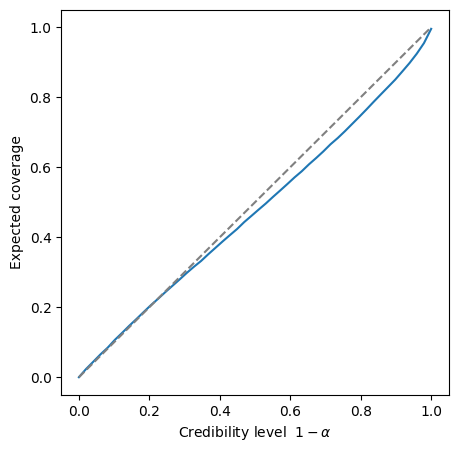

In [37]:
from plot_utils import calc_ecp 

def sample_func(x):
    x = x.to(device)
    threshold = normalize(1e-3, opt.output_features[0], opt.norm_param_dict)

    with torch.no_grad():
        gen, _ = model.generate(x, stop_criterion=threshold, prob_threshold=prob_threshold, max_ids=max_ids)  
    gen = gen.detach().cpu().numpy()
    seq_length = len(gen[0])   
    length_ij = calc_length(gen, threshold)
    mask = np.arange(seq_length)[None, :] >= length_ij[:, None] 
    gen[mask] = 0    
        
    return gen  

x_true_test = dataset_true.x
y_true_test = dataset_true.y_padded
mask_test = dataset_true.mask

### Select simulation data to use for ECP

Nsim = min(1000, len(x_true_test))
Nsim = len(x_true_test)

indices = np.random.choice(len(x_true_test), Nsim, replace=False)
x_true_test = x_true_test[indices]
y_true_test = y_true_test[indices]
mask_test = mask_test[indices]

### Define reference points
y_ref_name = "rand"
y_ref_name = "input"
y_ref_name = "marginal"

if y_ref_name == "rand":
    y_ref = np.random.rand(*y_true_test.shape)
elif y_ref_name == "input":
    y_ref = x_true_test[:, 0]
    y_ref = y_ref[:, None, None] + 0.5 * torch.rand(*y_true_test.shape) # (Nsim, seq_length, num_params)
else:
    idx = torch.randperm(dataset_true.y_padded.size(0))[:Nsim] 
    y_ref = dataset_true.y_padded[idx]

### Compute ECP
alpha = np.linspace(0, 1, 50)
ecp = calc_ecp(x_true_test, y_true_test, alpha, sample_func, y_ref=y_ref)

fout = "{}/ecp_Nsim{:d}_{}.txt".format(output_dir, Nsim, y_ref_name)
print("output {}".format(fout))
with open(fout, "w") as f:
    for a, e in zip(alpha, ecp):
        f.write("{:.4f} {:.4f}\n".format(a, e))

plt.figure(figsize=(5,5))
plt.plot(1-alpha, ecp)
plt.plot([0,1], [0,1], color="gray", ls="dashed")
plt.xlabel(r"Credibility level $\ 1 - \alpha$")
plt.ylabel("Expected coverage")


100%|██████████| 38746/38746 [42:17<00:00, 15.27it/s]  

output ../scripts/runs/output_transformer/transformer1_33_ep40_bs512_w0.02/figures/ecp_Nsim38746_marginal_shuffle.txt


Text(0, 0.5, 'Expected coverage')

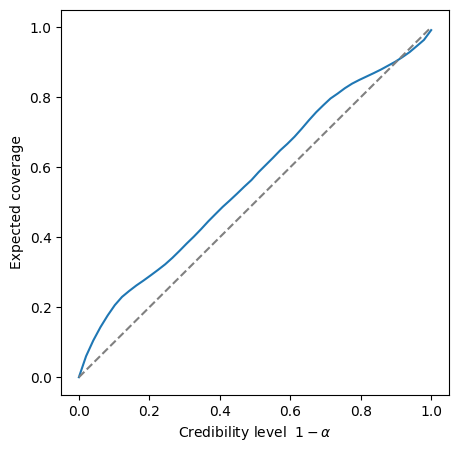

In [38]:
### Compute ECP with shuffled data
def sample_func_shuffle(x):
    gen = sample_func(x)

    # shuffle
    N, L, M = gen.shape
    gen_flat = gen.reshape(N*L, M)
    perm = torch.randperm(N*L)
    gen = gen_flat[perm].reshape(N, L, M)

    sfr = gen[:,:,0]
    idx = np.argsort(sfr, axis=1)[:,::-1]
    gen_sorted = np.take_along_axis(gen, idx[:,:,None], axis=1)
        
    return gen_sorted
 
ecp = calc_ecp(x_true_test, y_true_test, alpha, sample_func_shuffle, y_ref=y_ref)

fout = "{}/ecp_Nsim{:d}_{}_shuffle.txt".format(output_dir, Nsim, y_ref_name)
print("output {}".format(fout))
with open(fout, "w") as f:
    for a, e in zip(alpha, ecp):
        f.write("{:.4f} {:.4f}\n".format(a, e))

plt.figure(figsize=(5,5))
plt.plot(1-alpha, ecp)
plt.plot([0,1], [0,1], color="gray", ls="dashed")
plt.xlabel(r"Credibility level $\ 1 - \alpha$")
plt.ylabel("Expected coverage")

100%|██████████| 38746/38746 [01:33<00:00, 412.39it/s]

output ../scripts/runs/output_transformer/transformer1_33_ep40_bs512_w0.02/figures/ecp_Nsim38746_marginal_shuffle_all.txt


Text(0, 0.5, 'Expected coverage')

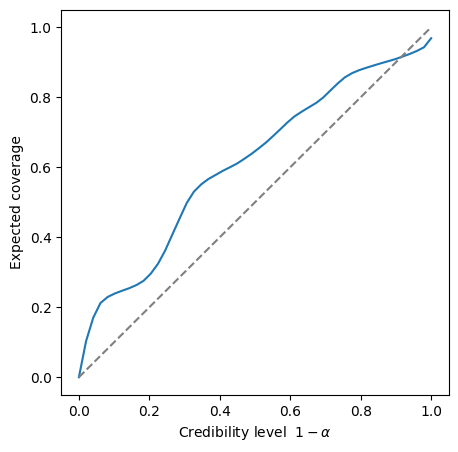

In [39]:
N, L, M = dataset_true.y_padded.shape
y_test_flat = dataset_true.y_padded.reshape(-1, M)
def sample_func_shuffle_all(x):
    x = x.to(device)
    n = len(x)

    indices = np.random.choice(N * L, n * L, replace=True)
    gen = y_test_flat[indices]
    gen = gen.reshape((n, L, M))
    gen = gen.detach().cpu().numpy()

    sfr = gen[:,:,0]
    idx = np.argsort(sfr, axis=1)[:,::-1]
    gen_sorted = np.take_along_axis(gen, idx[:,:,None], axis=1)

    return gen_sorted 

ecp = calc_ecp(x_true_test, y_true_test, alpha, sample_func_shuffle_all, y_ref=y_ref)

fout = "{}/ecp_Nsim{:d}_{}_shuffle_all.txt".format(output_dir, Nsim, y_ref_name)
print("output {}".format(fout))
with open(fout, "w") as f:
    for a, e in zip(alpha, ecp):
        f.write("{:.4f} {:.4f}\n".format(a, e))

plt.figure(figsize=(5,5))
plt.plot(1-alpha, ecp)
plt.plot([0,1], [0,1], color="gray", ls="dashed")
plt.xlabel(r"Credibility level $\ 1 - \alpha$")
plt.ylabel("Expected coverage")

1.2949000000000004
3.2374
6.078200000000001
Saved figure to ../scripts/runs/output_transformer/transformer1_33_ep40_bs512_w0.02/figures/TARP_marginal.pdf


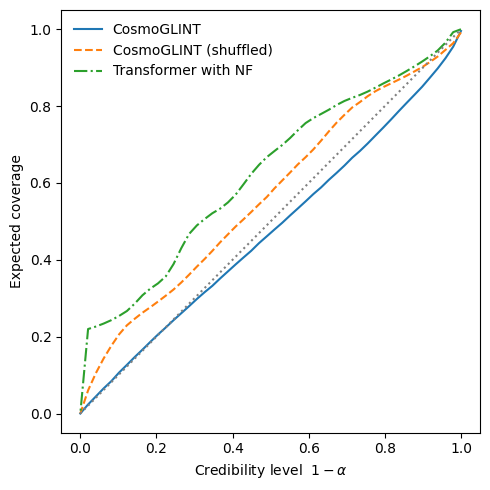

In [73]:
y_ref_name = "rand"
#y_ref_name = "input"
y_ref_name = "marginal"
Nsim = 1000
Nsim = 38746
fname_list = [
    "{}/ecp_Nsim{:d}_{}.txt".format(output_dir, Nsim, y_ref_name),
    "{}/ecp_Nsim{:d}_{}_shuffle.txt".format(output_dir, Nsim, y_ref_name),
    #"{}/ecp_Nsim{:d}_{}_shuffle_all.txt".format(output_dir, Nsim, y_ref_name),
    "../scripts/runs/output_transformer_nf/transformer1_33_normal_nc16_nl6_nf8_ep200_lr1e-4_use_vel/figures/ecp_Nsim{:d}_{}.txt".format(Nsim, y_ref_name)
]
label_list = [
    "CosmoGLINT",
    "CosmoGLINT (shuffled)", #"CosmoGLINT (shuffle within mass)",
    #"CosmoGLINT (shuffle all)",
    "Transformer with NF"
]
ls_list = [
    "solid", 
    "dashed", 
    #"dashed", 
    "dashdot"]

plt.figure(figsize=(5,5))

for i, fname in enumerate(fname_list):
    data = np.loadtxt(fname)
    alpha = data[:,0]
    ecp = data[:,1]

    plt.plot(1-alpha, ecp, label=label_list[i], ls=ls_list[i])

    print(np.abs(1-alpha-ecp).sum())

plt.plot([0,1], [0,1], color="gray", ls="dotted")
plt.xlabel(r"Credibility level $\ 1 - \alpha$")
plt.ylabel("Expected coverage")
plt.legend(frameon=False)
fout = f"{output_dir}/TARP_{y_ref_name}.pdf"
my_savefig(fout)

# Probability distribution

In [ ]:
## Probability
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

list_to_show = [10]

nbins_test = 40
xbins_test = np.linspace(0, 1, nbins_test+1)
xbin_indices_test = np.digitize(x_true, xbins_test) - 1 # (num_samples,)

num_to_show = 5
for i in list_to_show:
    indices = np.where(xbin_indices_test == i)[0]
    
    x_true_test = x_true[indices] 
    y_true_test = y_true[indices] 

    #shuffle = np.arange(len(x_true_test)-1,-1,-1)
    shuffle = np.random.permutation(len(x_true_test))

    i0 = shuffle[0]
    x_true_test = x_true_test[shuffle]
    y_true_test = y_true_test[shuffle]

    x_true_test = x_true_test[:num_to_show]
    y_true_test = y_true_test[:num_to_show]

    x_test = torch.tensor(x_true_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_true_test, dtype=torch.float32).to(device)

    with torch.no_grad():
        y_test = y_test[:,:-1]
        prob_test = model(x_test, y_test) #max_ids=max_ids)
    prob_test = prob_test.detach().cpu().numpy()

    threshold = normalize(1e-3, opt.output_features[0], opt.norm_param_dict)
    length_generated_test = calc_length(y_true_test, threshold)

    for j, (x, y) in enumerate(zip(x_true_test, y_true_test)):
        for iparam in range(opt.num_features_in):

            if iparam == 0:
                title = r"$\log M\ {/\rm M_\odot} \  =\ %.2f$" % (normalize(x.item(), opt.input_features[0], opt.norm_param_dict, inverse=True, convert=False))
                print("central SFR of {:d}th galaxy: {:.3f}".format(j, normalize(y[0,0], opt.output_features[0], opt.norm_param_dict, inverse=True)))
                show_legend = True
            else:
                #continue
                title = None
                if iparam == 1:
                    show_legend = True
                else:
                    show_legend = False
            
            
            show_prob(prob_test[j], y, length_generated_test[j], iparam=iparam, title=title, tag="_true_logm{:d}_{:d}".format(i,j), show_legend=show_legend, sample_label="True (TNG)") #, log_scale=True)           

In [ ]:
import matplotlib.gridspec as gridspec

cmap = plt.get_cmap("tab20")
colors = [cmap(i) for i in range(20)] * 10

threshold_phys = 1e-3
bin_of_threshold = int( normalize(threshold_phys, opt.output_features[0], opt.norm_param_dict) * opt.num_features_out )
def show_prob(prob, generated, length, iparam=0, title=None, ylim=(0, 0.18), log_scale=False, tag="", sample_label=None, separate_end_token=True, show_legend=True):
    if iparam == 0 and separate_end_token:
        fig = plt.figure(figsize=(6, 4.5))
    else:
        fig = plt.figure(figsize=(5.4, 4.8))
    #plt.title(title)
    plt.xticks([])
    plt.yticks([])

    if iparam == 0 and separate_end_token:
        ax = plt.gca()
        ax.spines["bottom"].set_visible(False)
        ax.spines["top"].set_visible(False)
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 20], wspace=0.08)
        ax = fig.add_subplot(gs[1])
        ax.set_xlim(1e-3, 1e3)

        ax_end_token = fig.add_subplot(gs[0])
        ax_end_token.set_ylabel("Probability")
        ax_end_token.set_xlim(0,1)
        ax_end_token.set_xticks([])
        ax_end_token.set_yticks([])
        ax_end_token.set_xlabel("End \n token")
        ax_end_token.set_ylim(0.0,1.01)
        #ax_end_token.hlines(1.0, 0,1,colors="gray", ls="--")
        
    else:
        ax = fig.add_subplot()
        ax.set_ylabel("Probability")

    ax.text(0.02, 0.98, title,
        transform=ax.transAxes, ha='left', va='top',
        fontsize=12, zorder=10,
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=2))
    
    convert = False if iparam == 2 else True
    val_phys = normalize( np.linspace(0, 1, opt.num_features_out), opt.output_features[iparam], opt.norm_param_dict, inverse=True, convert=convert)
    gen_phys = normalize( generated[:,iparam], opt.output_features[iparam], opt.norm_param_dict, inverse=True, convert=convert)

    if iparam != 2:
        ax.set_xscale("log")
    
    for k in range(length+1):
        label = f"{k}"
        if k == 0 and ( iparam == 1 or iparam == 2 ):
            continue
        if k != 0 and iparam != 0:
            prob[k,iparam,0] = 0.0

        prob[k,iparam,:] /= prob[k,iparam,:].sum()
        
        ax.plot(val_phys, prob[k,iparam], label=label, color=colors[k], alpha=0.8)
        if iparam == 0:
            prob_end_token = np.sum(prob[k,iparam,:bin_of_threshold])
            ax_end_token.hlines(prob_end_token, 0, 1, lw=4, colors=colors[k], alpha=0.8)
            #print(prob_end_token)
        
        if k < length:
            #height = ylim[1]*(0.9 - 0.03*k)
            height = ylim[1] * 0.85
            if iparam == 0 and gen_phys[k] <= threshold_phys:
                ax_end_token.scatter(0.5, height/ylim[1], marker="v", color=colors[k], s=100, alpha=0.8)
            else:
                ax.scatter(gen_phys[k], height, marker="v", color=colors[k], s=100, alpha=0.8)
        
    if log_scale:
        ax.set_yscale("log")
    else:
        ax.set_ylim(*ylim)
        ax.set_yticks([])

    ax.set_xlabel(f"{param_names[iparam]}")
    
    handles, labels = ax.get_legend_handles_labels()
    if sample_label is not None:
        import matplotlib.lines as mlines
        dummy_handles = mlines.Line2D([],[], color="gray", marker="v", linestyle="None", markersize=9, label=sample_label)
        handles = [dummy_handles] + handles
        labels = [sample_label] + labels

    if show_legend:
        ax.legend(handles, labels, frameon=False)

    if iparam == 2:
        xlim = plt.xlim()
        log_major_ticks_neg = np.arange(4, -1, -1)
        log_major_ticks_pos = np.arange(0, 5, 1)

        major_ticks_norm_neg = - np.log10(10**log_major_ticks_neg + 1)
        major_ticks_norm_pos = np.log10(10**log_major_ticks_pos + 1)
        #major_ticks_norm = np.concatenate([ major_ticks_norm_neg, [0], major_ticks_norm_pos ])
        major_ticks_norm = np.concatenate([ major_ticks_norm_neg, major_ticks_norm_pos ])

        major_labels_neg = [ r"$- 10^%.0f$" % (v) for v in log_major_ticks_neg ]
        major_labels_pos = [ r"$10^%.0f$" % (v) for v in log_major_ticks_pos ]               
        #major_labels = np.concatenate([ major_labels_neg, [r"$0$"], major_labels_pos ])
        major_labels = np.concatenate([ major_labels_neg, major_labels_pos ])
        
        minor_factors = np.array([ f1 * 10 ** f2 for f2 in range(0, 5) for f1 in range(2, 10) ])
        minor_pos = np.log10(minor_factors + 1)
        minor_ticks = np.concatenate([ -minor_pos[::-1], [0], minor_pos ])

        ax.set_xticks(major_ticks_norm)
        ax.set_xticklabels(major_labels)
        ax.set_xticks(minor_ticks, minor=True)

        plt.xlim(xlim)

    my_savefig("{}/prob{}_{}.pdf".format(output_dir, tag, param_labels[iparam])) #, tight_layout=False)

## Quick check of the output and probability
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

x_test_physical_unit = 12.00
x_test = np.array([10**x_test_physical_unit] * 10)
x_test = normalize(x_test, opt.input_features, opt.norm_param_dict)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
with torch.no_grad():
    generated_test, prob = model.generate(x_test, prob_threshold=1e-5, max_ids=max_ids)
generated_test = generated_test.detach().cpu().numpy()
prob = prob.detach().cpu().numpy()

threshold = normalize(threshold_phys, opt.output_features[0], opt.norm_param_dict)
length_generated_test = calc_length(generated_test, threshold)

for i, (x, g) in enumerate(zip(x_test, generated_test)):
    for iparam in range(opt.num_features_in):
        """
        print(f"{x.item():.4f}: ", end="")
        for j, gg in enumerate(g[:,iparam]):
            print(f"{gg:.4f} ", end="")
            if j == length_generated_test[i]:
                break

        print("| ")
        """

        if i < 2:
            if iparam == 0:
                title = r"$\log M\ {/\rm M_\odot} \  =\ %.2f$" % (x_test_physical_unit)
                show_legend = True
            else:
                title = " "
                show_legend = False
            
            show_prob(prob[i], g, length_generated_test[i], iparam=iparam, title=title, show_legend=show_legend, sample_label="Generated", tag="_{:d}".format(i)) #, log_scale=True)

# Spatial distribution

In [ ]:
seed = 12345
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Distribution of true galaxies
_nbins = 100
_xbins = np.linspace(0, 1, _nbins+1)
_xbins_physical_unit = normalize(np.repeat(_xbins[:,None], len(opt.input_features), axis=-1), opt.input_features, opt.norm_param_dict, inverse=True, convert=False)
_xbin_indices_true = np.digitize(x_true, _xbins) - 1 # (num_samples,)

list_to_show = [0, 25, 50] #, 74, 75]
ncols = 8
nrows = len(list_to_show)
plt.figure(figsize=(ncols*3, nrows*3))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
panel_id = 1
for count, i in enumerate(list_to_show):
    x_physical_unit = _xbins_physical_unit[i,0]
    print(_xbins_physical_unit[i,0], _xbins_physical_unit[i+1,0])
    mask = np.where(_xbin_indices_true == i)[0]
    
    ynow = y_true[mask]
    len_now = length_true[mask]

    indices = np.random.permutation(len(ynow))
    ynow= ynow[indices]
    len_now = len_now[indices]

    show_distribution(ynow[:ncols], len_now, x_physical_unit, panel_id=(nrows, ncols, panel_id), ylabel="log M = {:.1f}".format(x_physical_unit))
    panel_id = panel_id + ncols

my_savefig("{}/distribution_true.pdf".format(output_dir))

In [ ]:
seed = 12345
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def virial_radius(logM, z=0.0, delta_c=200, h=0.7, Omega_m=0.3, Omega_L=0.7):
    M = 10 ** logM
    G = 4.302e-9  # [Mpc * (km/s)^2 / Msun]
    Ez = np.sqrt(Omega_m * (1 + z)**3 + Omega_L)
    H_z = 100 * h * Ez
    rho_c_z = 3 * H_z**2 / (8 * np.pi * G)
    R_vir = (3 * M / (4 * np.pi * delta_c * rho_c_z))**(1/3)
    R_vir_mpc_h = R_vir * h
    return R_vir_mpc_h

def random_perpendicular_unit_vector(direction):
    N = len(direction)
    v_rand = np.random.randn(N, 3)
    dot = np.sum(v_rand * direction, axis=1, keepdims=True)
    v_tangent = v_rand - dot * direction
    v_tangent /= ( np.linalg.norm(v_tangent, axis=1, keepdims=True) + 1e-8 )

    return v_tangent

def show_distribution(gen, length, x_physical_unit, panel_id=[1,1,1], xmax_to_show=0.7, title_list=None, ylabel=None):
    if not isinstance(title_list, list):
        title_list = [None] * len(gen)

    if not isinstance(x_physical_unit, (list, np.ndarray)):
        x_physical_unit = [x_physical_unit] * len(gen)

    nrows, ncols, panel_id = panel_id

    for i, g in enumerate(gen):
    
        R = virial_radius(x_physical_unit[i])
        
        g = g[:length[i]]
        s = g[:,0] * 200
        
        g = normalize(g, opt.output_features, opt.norm_param_dict, inverse=True)

        d = g[:,1]
        vr = g[:,2]
        vt = g[:,3]
        
        phi = np.random.uniform(0, 2*np.pi, len(s))
        theta = np.arccos(np.random.uniform(-1, 1, len(s)))
        dir_vector = np.stack([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)], axis=1)
        pos = d[:,None] * dir_vector

        vel_para_vector = - vr[:,None] * dir_vector # (N, 3)
        vel_perp_vector = vt[:,None] * random_perpendicular_unit_vector(dir_vector) # (N, 3)
        vel_vector = vel_para_vector + vel_perp_vector # (N, 3)
        vel_vector *= 0.0005

        ax = plt.subplot(nrows,ncols, panel_id+i) #, projection="3d")
        ax.set_aspect('equal')

        plt.title(title_list[i], fontsize=15)
        
        for j in range(len(s)):
            ax.scatter(pos[j,0], pos[j,1], s=s[j], color=colors[j], zorder=np.sign(pos[j,2]), alpha=0.8)
            #plt.arrow(pos[j,0], pos[j,1], vel_vector[j,0], vel_vector[j,1], color=colors[j], width=0.005, head_length=0.02)
            
        ax.set_xlim(-xmax_to_show, xmax_to_show)
        ax.set_ylim(-xmax_to_show, xmax_to_show)

        circle = plt.Circle((0, 0), R, color='gray', fill=False, ls="dashed")
        ax.add_artist(circle)

        plt.xticks([])
        plt.yticks([])

        if i == 0:
            ax.set_ylabel(ylabel, fontsize=15)


x_phys_list = [11.001, 12, 13]
ncols = 8
nrows = len(x_phys_list)
plt.figure(figsize=(ncols*3, nrows*3))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
    
panel_id = 1
for i, x_physical_unit in enumerate(x_phys_list):
    if x_physical_unit == 12:
        gen_test = generated_test
        length_gen_test = length_generated_test
    else:
        x_test = np.array( [10 ** x_physical_unit] * 10 )
        x_test = normalize(x_test, opt.input_features, opt.norm_param_dict)
        x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
        with torch.no_grad():
            gen_test, _ = model.generate(x_test, prob_threshold=1e-5, max_ids=max_ids)
        gen_test = gen_test.detach().cpu().numpy()
        length_gen_test = calc_length(gen_test, threshold)
    
    ylabel = "log M = {:.2f}".format(x_physical_unit)
    show_distribution(gen_test[:ncols], length_gen_test, x_physical_unit, panel_id=(nrows, ncols, panel_id), ylabel=ylabel)
    panel_id = panel_id + ncols

my_savefig("{}/distribution.pdf".format(output_dir))



# Radial Profile

_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide


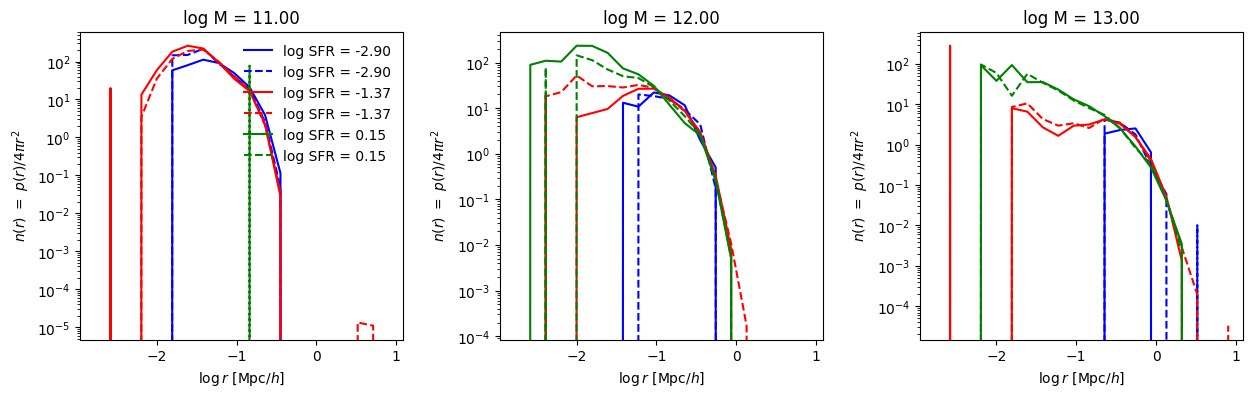

In [10]:
## radial profile
list_to_show = [0, 5, 10]
y_list_to_show = [1, 6, 11]
color_list = ["blue", "red", "green"]

plt.figure(figsize=(len(list_to_show)*5, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.2)
for count, i_logm in enumerate(list_to_show):
    plt.subplot(1, len(list_to_show), count+1)
    plt.title(f"log M = {xbins_physical_unit_in[i_logm, 0]:.2f}")
    base_mask = (xbin_indices_true == i_logm)
    for jj, j in enumerate(y_list_to_show):

        ls_list = ["-", "--"]
        for iy, ynow in enumerate([y_true, generated]):
            ynow = ynow[base_mask]
            bin_indices_now = np.digitize(ynow[:,:,0], xbins) - 1
            ynow = ynow[bin_indices_now == j]

            hist, bins = np.histogram(ynow[:,1], range=(threshold,1), bins=20, density=True)
            logr = normalize(bins, opt.output_features[1], opt.norm_param_dict, inverse=True, convert=False)
            
            logr = 0.5 * (logr[1:] + logr[:-1])
            hist /= 4 * np.pi * ( 10 ** logr ) ** 2

            plt.plot(logr, hist, label=f"log SFR = {xbins_physical_unit_out[j, 0]:.2f}", color=color_list[jj], ls=ls_list[iy])

    plt.yscale("log")
    
    if count == 0:
        plt.legend(frameon=False, loc="upper right")
    plt.ylabel(r"$n (r) \ = \ p(r) / 4\pi r^2$")
    plt.xlabel(r"$\log r \ [{\rm Mpc}/h] $")



# Visualize Attention Weights

Saved figure to ../scripts/runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02/figures/attn_layer_0.pdf
Saved figure to ../scripts/runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02/figures/attn_layer_1.pdf
Saved figure to ../scripts/runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02/figures/attn_layer_2.pdf
Saved figure to ../scripts/runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02/figures/attn_layer_3.pdf


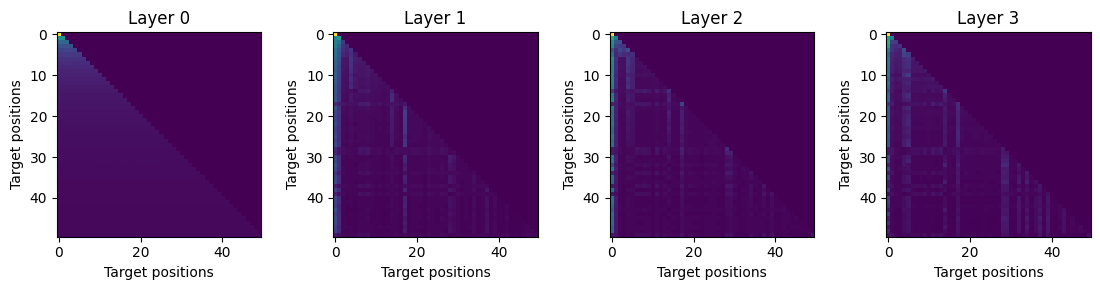

In [ ]:
### Transformer attention visualization
opt_now = copy.deepcopy(opt)
opt_now.model_name = opt.model_name + "_with_attn"
model_now = transformer_model(opt_now)
model_now.to(device)

model_now.load_state_dict(torch.load(f"{model_dir}/model.pth"))
model_now.eval()

attn_weights = {}

def get_hook(name):
    def hook(module, input, output):
        attn_weights[name] = output[1].detach().cpu() 
    return hook

for i, layer in enumerate(model_now.decoder.layers):
    layer.self_attn.register_forward_hook(get_hook(f'layer_{i}_self_attn'))

con = torch.from_numpy(x_true[0:1]).unsqueeze(-1).to(device)
seq = torch.from_numpy(y_true[0:1,:-1,:]).to(device)

with torch.no_grad():
    output = model_now(con, seq)

plt.figure(figsize=(3* opt_now.num_layers, 3))
for i in range(opt_now.num_layers):
    attn_matrix = attn_weights[f'layer_{i}_self_attn'][0].numpy()  # (tgt_len, tgt_len)

    plt.subplot(1, opt_now.num_layers, i + 1)
    plt.imshow(attn_matrix, cmap='viridis')
    #plt.colorbar()
    plt.title(f"Layer {i}")
    plt.xlabel("Target positions")
    plt.ylabel("Target positions")

    plt.tight_layout()
    my_savefig(f"{output_dir}/attn_layer_{i}.pdf")


# Distribution of True Galaxies